In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-retail-dataset/online_retail.csv


In [2]:
import pandas as pd
df = pd.read_csv('/kaggle/input/online-retail-dataset/online_retail.csv', encoding='ISO-8859-1')
print(df.head())
print(df.dtypes)

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2  2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object

In [3]:
#DATA CLEANING
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
print(df.dtypes)

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


In [4]:
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
reference_date = df['InvoiceDate'].max() + pd.DateOffset(1)
df['last_purchase_date'] = (reference_date - df['InvoiceDate']).dt.days

df['Frequency'] = df.groupby('CustomerID')['InvoiceNo'].transform('nunique')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


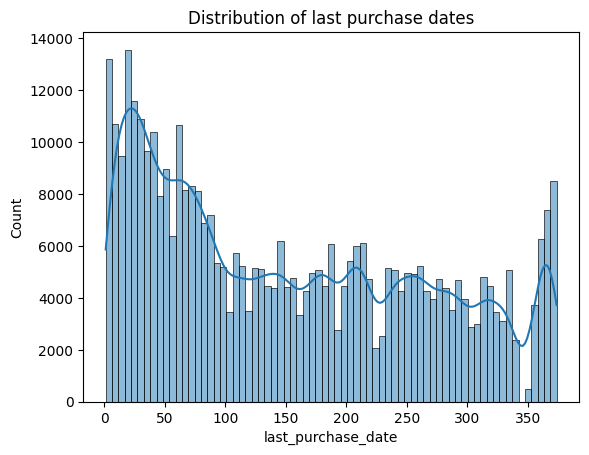

/tmp/ipykernel_18/1473383541.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['last_purchase_date'], shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


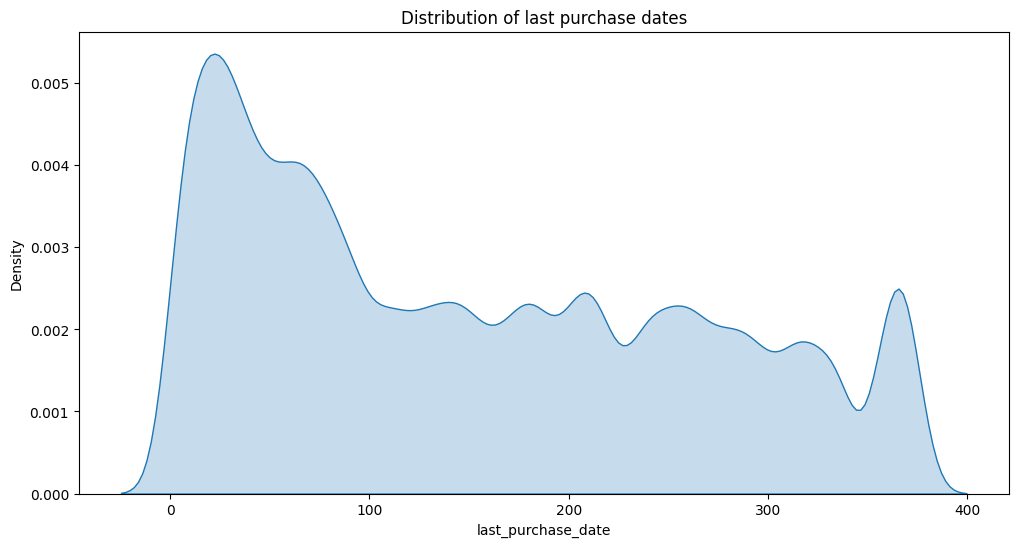

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


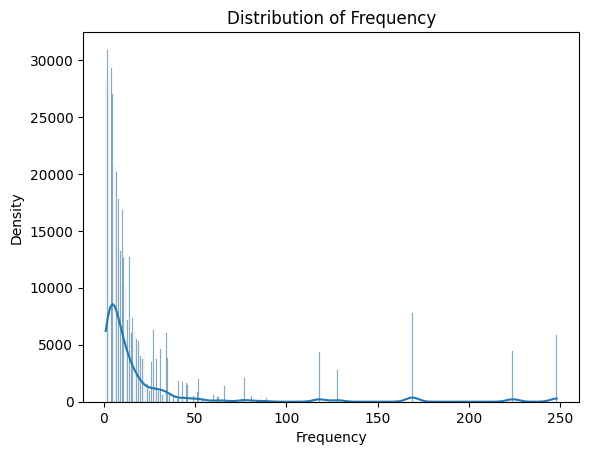

In [5]:
#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['last_purchase_date'], kde = True)
plt.title('Distribution of last purchase dates')
plt.show()

plt.figure(figsize=(12, 6))
sns.kdeplot(df['last_purchase_date'], shade=True)
plt.title('Distribution of last purchase dates')
plt.show()

sns.histplot(df['Frequency'], kde=True)
plt.title('Distribution of Frequency')
plt.xlabel('Frequency')
plt.ylabel('Density')
plt.show()

In [6]:
#CLUSTERING
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['last_purchase_date', 'Frequency', 'TotalAmount']])

In [7]:
#K-Means CLustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3)
kmeans.fit(df_scaled)

df['Cluster'] = kmeans.labels_

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


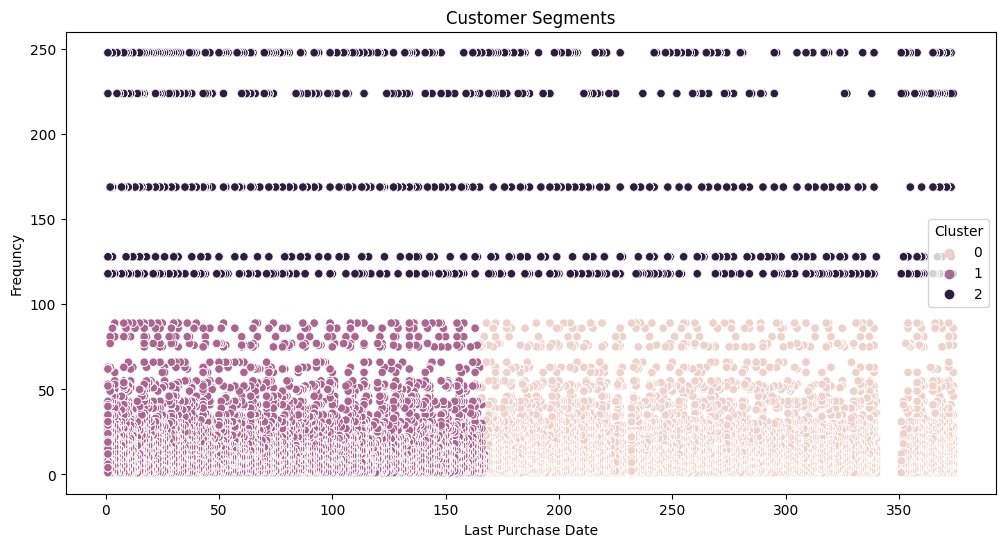

In [8]:
#Visualizing Clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(x='last_purchase_date', y='Frequency', hue='Cluster' , data=df)
plt.title('Customer Segments')
plt.xlabel('Last Purchase Date')
plt.ylabel('Frequncy')
plt.show()


In [9]:
#Analysing
cluster_summary = df.groupby('Cluster').agg({
    'last_purchase_date': 'mean',
    'Frequency': 'mean',
    'TotalAmount': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'}).reset_index()

print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
   Cluster  last_purchase_date   Frequency  TotalAmount   Count
0        0          267.615288   13.276028    21.709336  160980
1        1           67.082818   11.842964    21.467131  215364
2        2          147.123911  183.925614     6.354054   25260
